In [109]:
import pandas as pd
from java_migration.eval.smol_log_parser import parse_log
from pathlib import Path
import numpy as np
from java_migration.eval.utils import recover_safe_repo_name
import yaml
import pandas as pd
import seaborn as sns
from java_migration.utils import REPO_ROOT
import os
from collections.abc import MutableMapping
from java_migration.eval.maven_build_verifier import MavenBuildVerifier
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def flatten(dictionary, parent_key="", separator="_"):
    items = []
    for key, value in dictionary.items():
        new_key = parent_key + separator + key if parent_key else key
        if isinstance(value, MutableMapping):
            items.extend(flatten(value, new_key, separator=separator).items())
        else:
            items.append((new_key, value))
    return dict(items)


def visualize_agent_trace(trace, cmap_name="viridis"):
    """
    Visualizes an agent trace using a scatter plot.

    Parameters:
        trace (list of dict): Each dict should have keys 'step' and 'status'.
                              'status' is expected to be an enum with attributes `name` and `value`.
        cmap_name (str): The name of the matplotlib colormap to use for assigning colors.
    """
    # Extract unique statuses and sort them by their enum numeric value.
    statuses = sorted({item["status"] for item in trace}, key=lambda s: s.value)
    # Map each status to a numeric y-value based on its sorted order.
    status_to_y = {status: i for i, status in enumerate(statuses)}

    # Create a colormap instance from the specified colormap.
    cmap = plt.get_cmap(cmap_name)
    n_statuses = len(statuses)
    # Generate a color for each unique status based on the colormap.
    status_colors = {status: cmap(i / n_statuses) for i, status in enumerate(statuses)}

    # Prepare data for plotting.
    steps = [item["step"] for item in trace]
    y_values = [status_to_y[item["status"]] for item in trace]
    color_list = [status_colors[item["status"]] for item in trace]

    # Create a scatter plot with larger markers for prominence.
    plt.figure(figsize=(8, 4))
    plt.scatter(steps, y_values, s=200, c=color_list, edgecolors="black")

    # Set the y-axis ticks with the status names and enum values for clarity.
    plt.yticks(list(status_to_y.values()), [f"{status.name} ({status.value})" for status in statuses])
    plt.xlabel("Step")
    plt.ylabel("Status")
    plt.title("Agent Trace Visualization")
    plt.grid(True)
    plt.show()

In [6]:
def get_experiment_data(experiment_path):
    exp_dirs = [Path(f.path) for f in os.scandir(experiment_path / "job_results") if f.is_dir()]
    repo_names = [recover_safe_repo_name(f.name) for f in exp_dirs]

    repo_dict = {repo_name: {} for repo_name in repo_names}

    repo_feats_path = REPO_ROOT / "data" / "repo_feats.yaml"
    with open(repo_feats_path) as fin:
        repo_feats = yaml.safe_load(fin.read())

    for exp_dir, repo_name in zip(exp_dirs, repo_names):
        if (exp_dir / "stdout.log").exists():
            repo_dict[repo_name]["agent_log"] = parse_log(open(exp_dir / "stdout.log").read())
        if (exp_dir / "result.yaml").exists():
            with open(exp_dir / "result.yaml") as fin:
                repo_dict[repo_name]["build_result"] = yaml.safe_load(fin.read())
        if repo_name in repo_feats:
            repo_dict[repo_name]["repo_feats"] = repo_feats[repo_name]

    return repo_dict


experiment_path = Path(
    "/Users/mayvic/Documents/git/java-migration-paper/data/experiments/2025-03-09/22-19-56-hopeful-wescoff"
)
exp_data = get_experiment_data(experiment_path)

In [7]:
def get_experiment_features(exp_data):
    exp_feats = []
    for repo_name, repo_data in exp_data.items():
        cur_feats = {"repo_name": repo_name}
        if "build_result" in repo_data and repo_data["build_result"] is not None:
            cur_feats.update(flatten(repo_data["build_result"]))
        exp_feats.append(cur_feats)
        if "agent_log" in repo_data:
            cur_feats["run_duration"] = np.sum([y.meta.duration for y in repo_data["agent_log"].steps])
            cur_feats["input_tokens"] = np.sum([y.meta.input_tokens for y in repo_data["agent_log"].steps])
            cur_feats["output_tokens"] = np.sum([y.meta.input_tokens for y in repo_data["agent_log"].steps])
            cur_feats["num_steps"] = len(repo_data["agent_log"].steps)
        if "repo_feats" in repo_data:
            cur_feats.update(repo_data["repo_feats"])

    return exp_feats


exp_features = get_experiment_features(exp_data)
df = pd.DataFrame(exp_features)

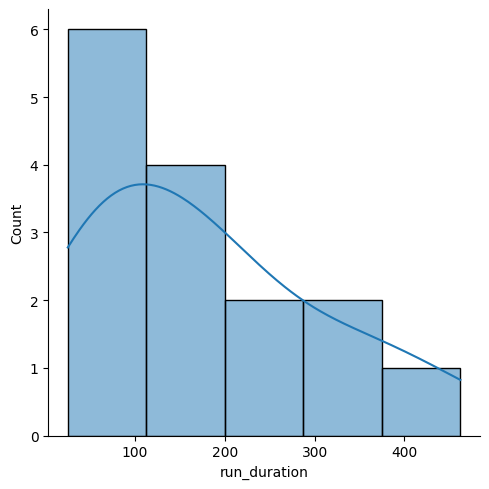

In [8]:
# df.run_duration.hist()

sns.displot(data=df["run_duration"], kde=True)

<Axes: xlabel='number_of_java_files', ylabel='num_steps'>

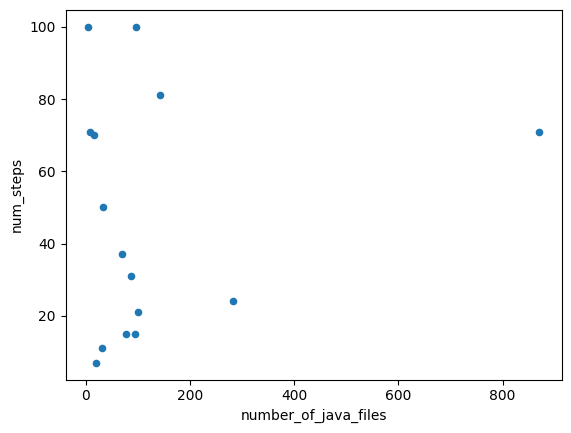

In [14]:
df.plot(x="number_of_java_files", y="num_steps", kind="scatter")

In [15]:
df

,repo_name,build_result_build_success,build_result_test_results_errors,build_result_test_results_failures,build_result_test_results_skipped,build_result_test_results_tests_run,build_result_test_success,error,run_success,run_duration,input_tokens,output_tokens,num_steps,build_tool,number_of_external_dependencies,number_of_java_files,number_of_lines_of_code,number_of_modules,number_of_unit_tests,build_result_test_results
0,DeemOpen/zkui,True,0.0,0.0,0.0,0.0,True,None,True,25.17,124694,124694,7,maven,28,20,2222,1,0,NaN
1,EalenXie/spring-microservice-ddd,True,0.0,0.0,0.0,0.0,True,None,True,160.52,45700780,45700780,50,maven,14,34,2053,1,1,NaN
2,killme2008/aviatorscript,True,0.0,0.0,0.0,1712.0,True,None,True,92.97,1392360,1392360,24,maven,12,283,47969,1,643,NaN
3,ata4/disunity,True,0.0,0.0,0.0,328.0,True,None,True,49.79,736568,736568,15,maven,12,95,7250,3,6,NaN
4,opengoofy/hippo4j,True,NaN,NaN,NaN,NaN,True,None,True,350.63,147910973,147910973,71,maven,48,870,69708,8,423,NaN
5,EnterpriseQualityCoding/FizzBuzzEnterpriseEdition,True,2.0,0.0,0.0,2.0,False,None,True,88.52,8133347,8133347,31,maven,12,87,2489,1,1,NaN
6,perwendel/spark,True,NaN,NaN,NaN,NaN,True,None,True,174.69,4187580,4187580,21,maven,28,100,13947,1,320,NaN
7,alibaba/QLExpress,False,NaN,NaN,NaN,NaN,None,None,True,462.36,616745830,616745830,81,maven,10,142,10938,1,193,NaN
8,SPuerBRead/Bridge,True,NaN,NaN,NaN,NaN,True,None,True,31.09,452263,452263,11,maven,16,32,2408,1,0,NaN
9,joelittlejohn/jsonschema2pojo,False,NaN,NaN,NaN,NaN,None,None,True,360.50,449697137,449697137,100,maven,101,96,15097,6,671,NaN


In [20]:
df[(df.build_result_test_success == False) | (df.build_result_build_success == False)].repo_name.tolist()

['EnterpriseQualityCoding/FizzBuzzEnterpriseEdition',
 'alibaba/QLExpress',
 'joelittlejohn/jsonschema2pojo',
 'Netflix/Surus',
 'nydiarra/springboot-jwt',
 'Codecademy/EventHub']

In [19]:
df[
    [
        "number_of_unit_tests",
        "number_of_modules",
        "number_of_lines_of_code",
        "number_of_java_files",
        "num_steps",
        "input_tokens",
        "output_tokens",
    ]
].corr()

,number_of_unit_tests,number_of_modules,number_of_lines_of_code,number_of_java_files,num_steps,input_tokens,output_tokens
number_of_unit_tests,1.000000,0.440755,0.714425,0.514299,0.251236,0.176336,0.176336
number_of_modules,0.440755,1.000000,0.585878,0.650125,0.186198,0.039681,0.039681
number_of_lines_of_code,0.714425,0.585878,1.000000,0.937103,0.070935,-0.061268,-0.061268
number_of_java_files,0.514299,0.650125,0.937103,1.000000,0.133400,-0.029992,-0.029992
num_steps,0.251236,0.186198,0.070935,0.133400,1.000000,0.852597,0.852597
input_tokens,0.176336,0.039681,-0.061268,-0.029992,0.852597,1.000000,1.000000
output_tokens,0.176336,0.039681,-0.061268,-0.029992,0.852597,1.000000,1.000000


In [21]:
df.run_duration.mean()

np.float64(178.12533333333334)

In [113]:
from enum import Enum


class MavenStatus(Enum):
    NO_MAVEN = 0
    COMPILE_ERROR = 1
    TESTS_STARTED = 2
    SUCCESS = 3
    DEPENDENCY_ERROR = 4
    UNKNOWN_ERROR = 5
    UNKNOWN = 6
    GOAL_ERROR = 7
    PLUGIN_RESOLVE_ERROR = 8
    INVALID_POM = 9
    SKIPPED_TESTS = 10


def step_log_maven_status(log: str):
    if "Scanning for projects" not in log:
        return MavenStatus.NO_MAVEN
    if "Non-parseable POM" in log or "Malformed POM" in log:
        return MavenStatus.INVALID_POM
    if "COMPILATION ERROR" in log:
        return MavenStatus.COMPILE_ERROR
    if "Could not resolve dependencies for project" in log:
        return MavenStatus.DEPENDENCY_ERROR
    if "Tests are skipped." in log:
        return MavenStatus.SKIPPED_TESTS
    if "BUILD SUCCESS" in log:
        return MavenStatus.SUCCESS
    if "Tests run" in log:
        return MavenStatus.TESTS_STARTED
    if "one of its dependencies could not be resolved" in log:
        return MavenStatus.PLUGIN_RESOLVE_ERROR
    if "Failed to execute goal" in log:
        return MavenStatus.GOAL_ERROR
    if "BUILD FAILURE" in log:
        return MavenStatus.UNKNOWN_ERROR
    return MavenStatus.UNKNOWN


def get_maven_logs(repo_data):
    maven_statuses = [
        {"step": idx, "status": step_log_maven_status(x.execution_logs)}
        for idx, x in enumerate(repo_data["agent_log"].steps)
        if x.execution_logs
    ]
    return [x for x in maven_statuses if x["status"] != MavenStatus.NO_MAVEN]


maven_logs = {repo_name: get_maven_logs(exp_data[repo_name]) for repo_name in exp_data}

In [118]:
repo_names = df.repo_name.tolist()

maven_logs[repo_names[1]]

[{'step': 5, 'status': <MavenStatus.COMPILE_ERROR: 1>},
 {'step': 16, 'status': <MavenStatus.COMPILE_ERROR: 1>},
 {'step': 18, 'status': <MavenStatus.COMPILE_ERROR: 1>},
 {'step': 20, 'status': <MavenStatus.SUCCESS: 3>},
 {'step': 22, 'status': <MavenStatus.SUCCESS: 3>},
 {'step': 24, 'status': <MavenStatus.SUCCESS: 3>},
 {'step': 48, 'status': <MavenStatus.SUCCESS: 3>}]

In [137]:
maven_statuses_by_repo = {
    repo_name: set([step["status"] for step in maven_logs[repo_name]]) for repo_name in maven_logs
}
status_incidence = dict(zip(ini_dict.values(), ini_dict.keys()))

{'DeemOpen/zkui': {<MavenStatus.GOAL_ERROR: 7>, <MavenStatus.SUCCESS: 3>},
 'EalenXie/spring-microservice-ddd': {<MavenStatus.COMPILE_ERROR: 1>,
  <MavenStatus.SUCCESS: 3>},
 'killme2008/aviatorscript': {<MavenStatus.SUCCESS: 3>,
  <MavenStatus.TESTS_STARTED: 2>},
 'ata4/disunity': {<MavenStatus.COMPILE_ERROR: 1>, <MavenStatus.SUCCESS: 3>},
 'opengoofy/hippo4j': {<MavenStatus.DEPENDENCY_ERROR: 4>,
  <MavenStatus.SKIPPED_TESTS: 10>,
  <MavenStatus.TESTS_STARTED: 2>},
 'EnterpriseQualityCoding/FizzBuzzEnterpriseEdition': {<MavenStatus.COMPILE_ERROR: 1>,
  <MavenStatus.PLUGIN_RESOLVE_ERROR: 8>,
  <MavenStatus.TESTS_STARTED: 2>},
 'perwendel/spark': {<MavenStatus.DEPENDENCY_ERROR: 4>,
  <MavenStatus.SKIPPED_TESTS: 10>,
  <MavenStatus.TESTS_STARTED: 2>},
 'alibaba/QLExpress': {<MavenStatus.INVALID_POM: 9>,
  <MavenStatus.TESTS_STARTED: 2>},
 'SPuerBRead/Bridge': {<MavenStatus.COMPILE_ERROR: 1>,
  <MavenStatus.GOAL_ERROR: 7>,
  <MavenStatus.SUCCESS: 3>},
 'joelittlejohn/jsonschema2pojo': {<M

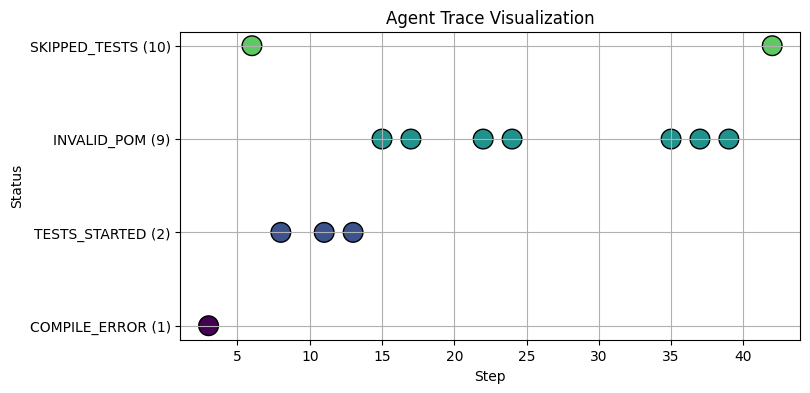

anjia0532/unidbg-boot-server


In [136]:
# print(exp_data[repo_names[12]]["agent_log"].steps[15].execution_logs)
visualize_agent_trace(maven_logs[repo_names[12]])
print(repo_names[12])

In [121]:
print(exp_data[repo_names[1]]["agent_log"].steps[48].execution_logs)

[INFO] Scanning for projects...
[WARNING] 
[WARNING] Some problems were encountered while building the effective model for com.github.ealen:spring-microservice-ddd:jar:1.0
[WARNING] 'dependencies.dependency.(groupId:artifactId:type:classifier)' must be unique: 
org.springframework.boot:spring-boot-starter-validation:jar -> duplicate declaration of version (?) @ line 55, column 17
[WARNING] 'dependencies.dependency.(groupId:artifactId:type:classifier)' must be unique: 
org.springframework.boot:spring-boot-starter-validation:jar -> duplicate declaration of version (?) @ line 61, column 21
[WARNING] 
[WARNING] It is highly recommended to fix these problems because they threaten the stability of your build.
[WARNING] 
[WARNING] For this reason, future Maven versions might no longer support building such malformed projects.
[WARNING] 
[INFO] 
[INFO] --------------< com.github.ealen:spring-microservice-ddd >--------------
[INFO] Building spring-microservice-ddd 1.0
[INFO]   from pom.xml
[INF